# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import importlib

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

%load_ext autoreload
%autoreload 2
import SylliGraph
importlib.reload(SylliGraph)
sgraph = SylliGraph.SylliGraph(experiment_path)

In [12]:
result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]

df = pd.DataFrame()
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(sgraph.formal_names)
df.sample(2)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:00<00:00, 362.95it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
1803,syn_len_100000_n_5_avglen_10.npz,100000,5,10.000000,FF-VUS (L: 128),0.567518,0.072841,128.0,1.0,True,...,0.000182,0.001004,0.005102,0.025088,0.000286,0.0007,0.000566,0.03277,0.000208,0.000119
3275,syn_len_100000_n_100_avglen_10.npz,100000,99,10.060606,RF,0.817382,0.396033,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Global execution time comparison

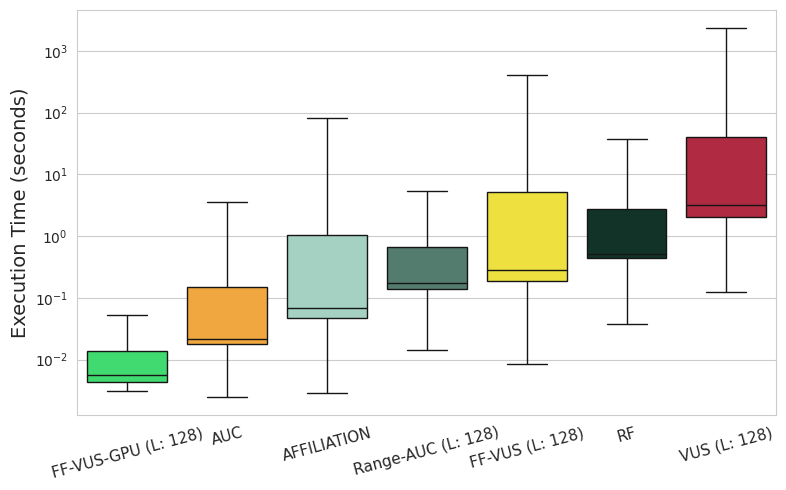

Saved boxplot to ../../experiments/allmetrics_defparams_syn/figures/exec_time_comparison_syn


In [ ]:
# TODO: Find why there is this big lines per metric, what affects this
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

sgraph.boxplot_exec_time(df=df, order=order, filename='exec_time_comparison_syn', title='', xlabel='', ylabel='Execution Time (seconds)')

## Time series characteristics runtime analysis

Total number of time series: 190
Total number of points: 42949591040, 42949591k, 42949m, 42b
Length -> min: 8192, max: 2147483648
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 9.9, max: 11.0


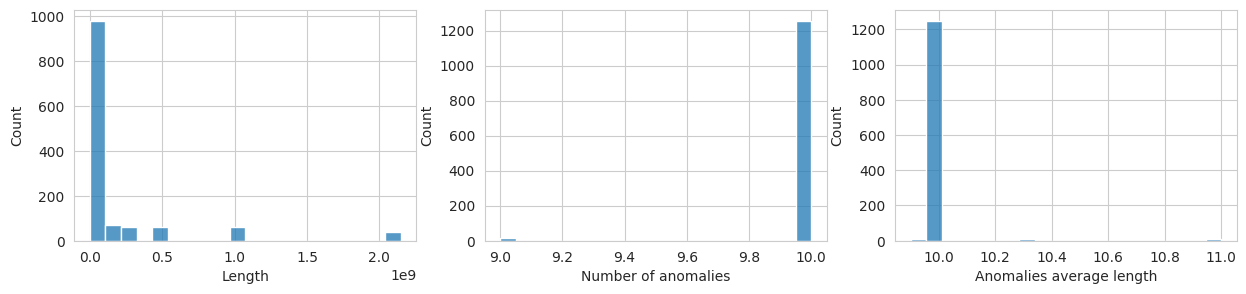

Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 1, max: 920
Anomalies average length -> min: 10.0, max: 10.5906288532676


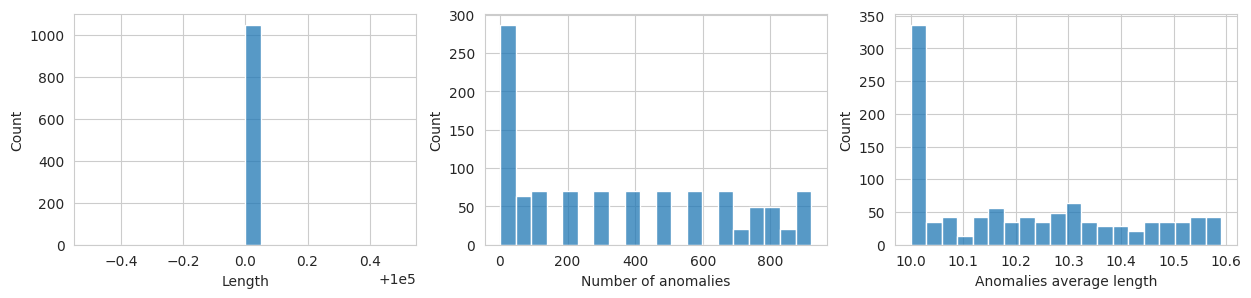

Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 1.0, max: 1050.88888888889


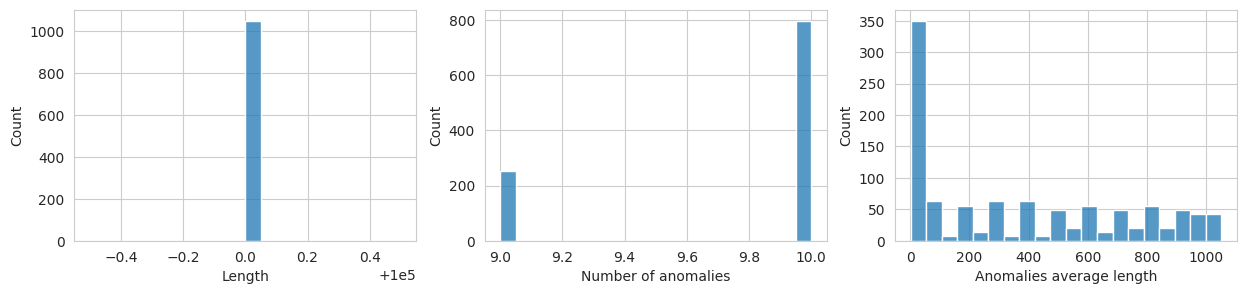

In [6]:
# df = df[~df['Length'].isin([8192, 2147483648])].reset_index(drop=True)

length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]

sgraph.plot_dataset_insights(length_analysis_df, "length")
sgraph.plot_dataset_insights(n_anomalies_analysis_df, "num_of_anomalies")
sgraph.plot_dataset_insights(avg_anomaly_length_analysis_df, "avg_anomaly_length")

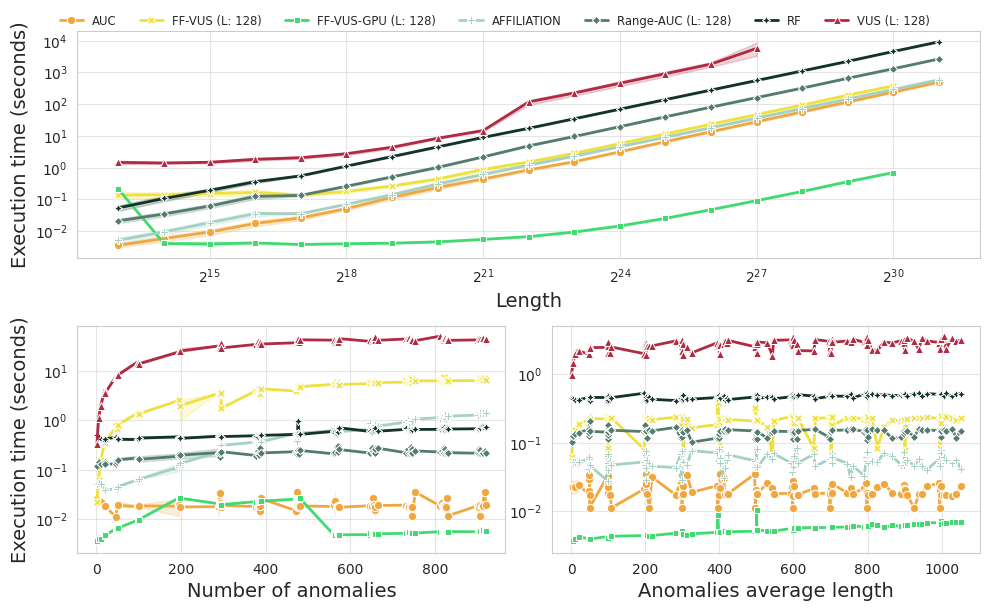

In [9]:
# Pass your 3 dataframes for the analysis
analysis_dfs = [
    length_analysis_df, 
    n_anomalies_analysis_df, 
    avg_anomaly_length_analysis_df
]

# Generate and save the figure
sgraph.plot_exec_time_per_attr(analysis_dfs, filename='exec_time_per_ts_char_syn')

## Computation step runtime analysis

NameError: name 'color_palette' is not defined

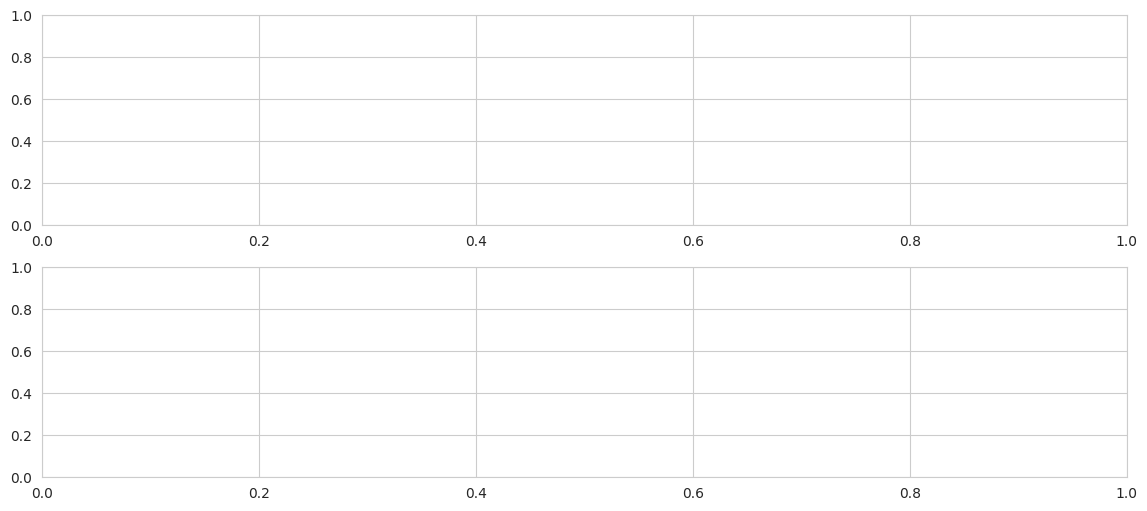

In [13]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharey=False)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(curr_df[curr_df['Metric'] == metrics[j]], ax=axis, x=i, y=col, log_scale=True, legend=(i == 0), color=color_palette[metrics[j]], showfliers=False)
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])
        axis.set_title(metrics[j])
        axis.set_ylabel('Runtime (sec)')
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

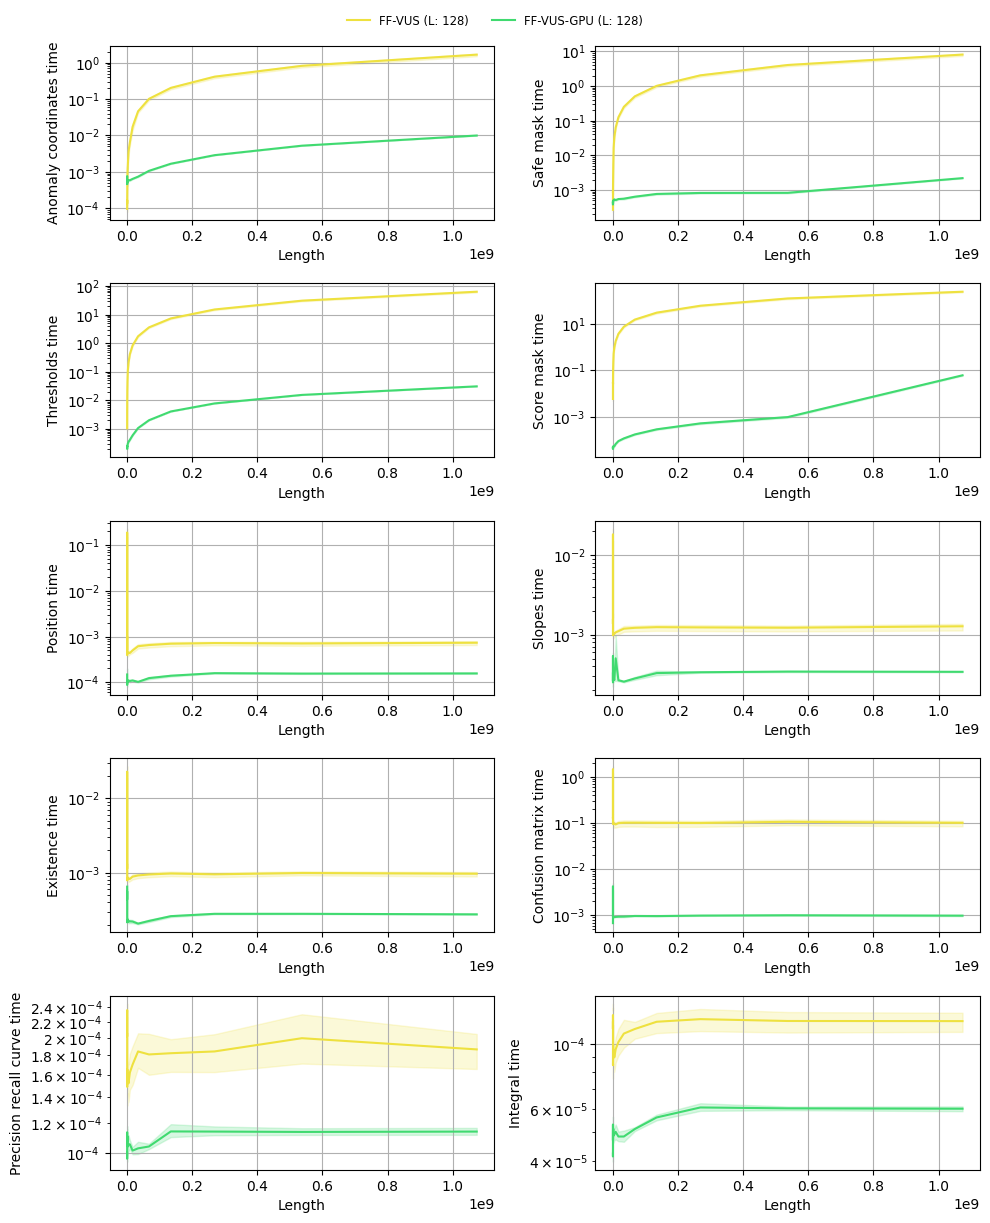

In [95]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

legend_axis = None
for col, axis in zip(time_analysis_cols, ax.flatten()):
    sns.lineplot(
        curr_df, 
        x='Length', 
        y=col, 
        hue='Metric', 
        ax=axis, 
        legend=(col == 'Anomaly coordinates time'), 
        palette=color_palette
    )
    axis.set_yscale('log')
    axis.grid()
    
    legend_axis = axis if legend_axis is None else legend_axis
    
handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.show()

## Error evaluation

In [19]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    syn_file_index = file[:6]
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()
    curr_df = curr_df.replace('syn_', syn_file_index, regex=True)
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 327.38it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
3046,syn_8_len_131072_n_10_avglen_10.npz,131072,10,10.0,Range-AUC (L: 128),0.148627,0.117250,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2971,syn_5_len_100000_n_10_avglen_1.npz,100000,10,1.0,RF,0.021645,0.446965,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2592,syn_0_len_67108864_n_10_avglen_10.npz,67108864,10,10.0,VUS (L: 128),0.888001,2227.429639,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


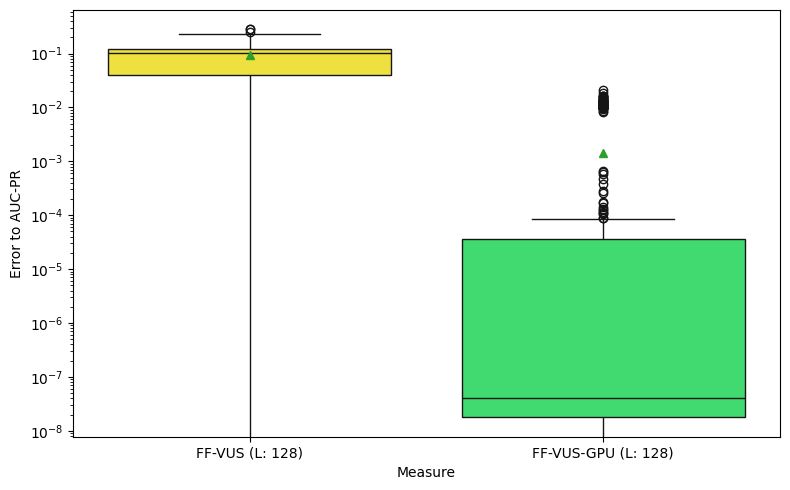

In [29]:
# What is the error between the difference metrics
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')
plt.figure(figsize=(8, 5))

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
values_df = values_df.loc[vus_df.index]
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()

sns.boxplot(dif_df, showfliers=True, palette=color_palette, saturation=1, showmeans=True)
# sns.violinplot(dif_df, palette=color_palette, saturation=1)
plt.xlabel('Measure')
plt.ylabel('Error to AUC-PR')
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
plt.show()

In [30]:
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    dif_df[attr] = dif_df.apply(
        lambda row: df.loc[df['Time series'] == row.name, attr].values[0],
        axis=1
    )
dif_df

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128),Length,Number of anomalies,Anomalies average length
Time series,,,,,
syn_6_len_8192_n_10_avglen_10.npz,2.114863e-02,6.016820e-08,8192,9,11.0
syn_6_len_16384_n_10_avglen_10.npz,2.903921e-02,2.032425e-08,16384,10,10.0
syn_6_len_32768_n_10_avglen_10.npz,1.975193e-01,8.244107e-05,32768,10,10.0
syn_6_len_65536_n_10_avglen_10.npz,1.854191e-01,3.346145e-08,65536,10,10.0
syn_6_len_100000_n_1_avglen_10.npz,7.771561e-16,5.639477e-08,100000,1,10.0
...,...,...,...,...,...
syn_8_len_8388608_n_10_avglen_10.npz,1.147180e-01,3.489784e-08,8388608,10,10.0
syn_8_len_16777216_n_10_avglen_10.npz,1.010170e-01,4.716874e-08,16777216,10,10.0
syn_8_len_33554432_n_10_avglen_10.npz,1.021223e-01,6.296268e-08,33554432,10,10.0


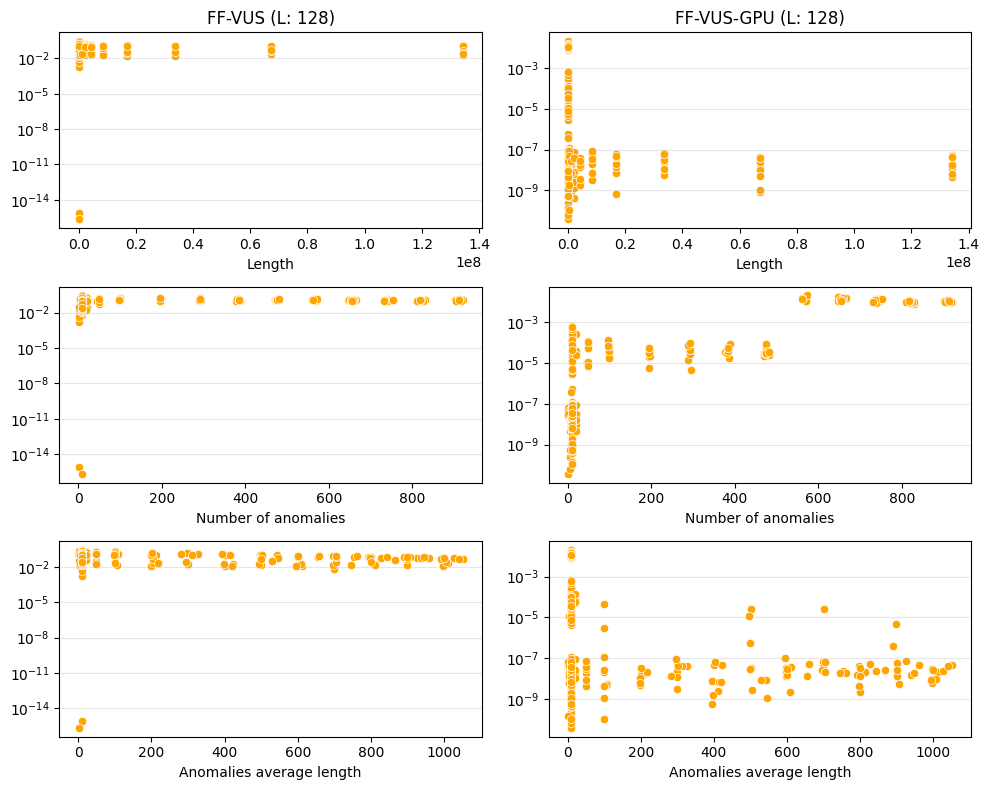

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
curr_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
for i, attr in enumerate(attributes):
    for j, metric in enumerate(curr_metrics):
        sns.scatterplot(dif_df, y=metric, x=attr, ax=ax[i, j], color='orange')
        ax[i, j].set_yscale('log')
        ax[i, j].grid(axis='y', alpha=0.3)
        ax[i, j].set_ylabel('')
        if i == 0:
            ax[i, j].set_title(metric)
        

plt.tight_layout()
plt.show()